## Final Project Submission

Please fill out:
* Student name: Nikki Wood
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Mark Barbour
* Blog post URL:


In [1]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import zipfile
import sqlite3
import gzip
import ast
import os
import re


## Business Understanding

Our company is looking to enter the movie production industry by creating a new movie studio. However, we lack experience and insights into what types of films are currently performing well at the box office. The goal of this project is to conduct exploratory data analysis on various movie datasets to uncover trends and patterns that can guide our decision-making process when it comes to selecting the genres, themes, and styles of films to produce.

The key objectives are:

- Analyze box office performance data to identify the most successful and popular movie genres, themes, and styles in recent years.
- Explore factors that contribute to a film's success, such as critical reviews, audience ratings, production budgets, and marketing strategies.
- Generate actionable insights and recommendations for the head of our new movie studio, providing data-driven guidance on the types of films they should consider producing to maximize potential returns.

By leveraging data from reputable sources like Box Office Mojo, IMDB, Rotten Tomatoes, TheMovieDB, and The Numbers, we aim to gain a comprehensive understanding of the current movie landscape and audience preferences. This will enable us to make informed decisions and increase our chances of creating successful and profitable films.

## Data Understanding

Before we dive into analyzing this data, let's get familiar with what we're working with:


In [2]:
# Box Office Mojo
bom_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz', compression='gzip')

# The Numbers
tn_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip')

# Rotten Tomatoes
rt_reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', compression='gzip', sep='\t', encoding='latin-1')
rt_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', compression='gzip', sep='\t')

# TheMovieDB
tmdb_movies = pd.read_csv('zippedData/tmdb.movies.csv.gz', compression='gzip')

For the IMDB data, which is in a SQLite database, we'll need to connect to it and query the tables we want. It looks like with sqlite database files, we have to extract it first. So lets do that, (and put the temp dir into our git ignore!)

In [3]:
temp_dir = 'temp'
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

# Get the current working directory
cwd = os.getcwd()

# Construct the full path to the zipped file
zip_file_path = os.path.join(cwd, 'zippedData', 'im.db.zip')

# Extract zip file to temp dir
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

# Path to the extracted database file
db_file = os.path.join(temp_dir, 'im.db')

# Connect to the database
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

imdb_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)


In [4]:
# big boy queries
imdb_ratings = pd.read_sql_query("""SELECT
    ib.movie_id,
    ib.primary_title, 
    ib.original_title,
    ib.runtime_minutes,
    ib.genres,
    mr.averagerating,
    mr.numvotes,
    d.primary_name AS director,
    w.primary_name AS writer
FROM
    movie_basics ib
LEFT JOIN
    movie_ratings mr ON ib.movie_id = mr.movie_id  
LEFT JOIN
    (
        SELECT
            d.movie_id,
            p.primary_name
        FROM
            directors d
        JOIN
            persons p ON d.person_id = p.person_id
    ) d ON ib.movie_id = d.movie_id
LEFT JOIN
    (
        SELECT
            w.movie_id, 
            p.primary_name
        FROM
            writers w
        JOIN
            persons p ON w.person_id = p.person_id
    ) w ON ib.movie_id = w.movie_id;
""", conn)

### bom_gross
*Box Office Mojo*

This data provides a high-level financial overview for movies - how much money they made both at home and abroad, as well as which studio put it out and the year it hit theaters. Very useful for analyzing box office performance and studio revenues.

- title - The name/title of the movie
- studio - The production studio behind the movie
- domestic_gross - The total box office revenue earned domestically (within the movie's home country)
- foreign_gross - The total box office revenue earned internationally/overseas
- year - The year the movie was released

### tn_budgets
*The Numbers*

This table has release specifics like dated revenues and ties them back to the production budget. It allows for analysis of how a movie performed versus its budget over different release windows or re-releases.

- release_date - The date this particular release/run hit theaters
- movie - The movie title
- production_budget - The budget/cost to produce this movie
- domestic_gross - Box office revenue earned domestically for this release
- worldwide_gross - Total global box office revenue for this release

### rt_reviews
*Rotten Tomatoes*

This table contains review information, tracking perception of a movie over time.

- review - The actual text content of the movie review
- rating - The numeric rating or score given by the critic (e.g. 3 out of 5 stars)
- fresh - Possibly a binary flag indicating if the review was favorable/fresh or rotten
- critic - The name of the critic who wrote the review
- top_critic - A flag denoting if this is a top/renowned critic or not
- publisher - The publication, website or outlet where the review was published
- date - The date the review was published


### rt_info
*Rotten Tomatoes*

This table holds key attributes for movie info: genre, creators, release dates, etc. Allows us to analyze relationships between a movie's characteristics and its performance. Very valuable for studios doing green-lighting decisions.

- synopsis - A brief summary or description of the movie's plot
- rating - The MPAA rating (G, PG, R, etc.)
- genre - The genre(s) the movie falls under (comedy, action, drama, etc.)
- director - The name(s) of the director(s)
- writer - The writer(s) who wrote the screenplay
- theater_date - The date the movie was released in theaters
- dvd_date - The date the DVD/home video was released
- currency - The currency the box office numbers are in
- box_office - The total box office revenue earned
- runtime - The duration/length of the movie
- studio - The production studio behind the movie

### tmdb_movies
*TheMovieDB*

This looks to be the main movie metadata table. Valuable for knowing what elements resonate with the viewers.

- genre_ids - Likely contains ids representing the different genres a movie belongs to
- id - A unique identifier for each movie
- original_language - The language the movie was originally produced in
- original_title - The original titled the movie was released under
- popularity - Possibly a metric capturing how popular/trending the movie is
- release_date - The date the movie was released in theaters
- title - The title the movie is best known by
- vote_average - The average rating/score the movie received based on audience votes
- vote_count - The number of audience vote/rating entries the average is based on

## Data Preperation and Cleaning


Completeness: Addressing missing or incomplete data entries

Consistency: Ensured uniformity in data formats and representations

Accuracy: Identified and corrected any erroneous or invalid values

Relevance: Filtered out irrelevant or redundant features

To meet these objectives, we will

- Merge the necessary datasets
- Identify columns with missing values and decide whether to drop them
- Split genres column in IMDB and create new columns for each genre ?
- Convert date columns to a consistent format (datetime)
- Remove outliars for relevant information
- check for invalid or out-of-range values
- review merged dataset, drop any irrelevant or redundant columns

## Merge the necessary datasets

#### Merging IMDB tables

First, lets move all the data we care about into the same data frame. 

rt_info:
id synopsis rating genre director writer theater_date dvd_date currency box_office runtime studio
  use: imdb table 'persons': director, writer (or maybe theater_date ? idk yet)

tmdb_movies:
genre_ids id original_language original_title popularity release_date title vote_average vote_count release_year rating_category
  use: original_title

rt_reviews:
id review rating fresh critic top_critic publisher date
use: not sure :<

tn_budgets:
id release_date movie production_budget domestic_gross worldwide_gross
  use: movie (should be title), release_date ?

bom_gross:
title studio domestic_gross foreign_gross year
  use: title


In [8]:
# Merge imdb_basics and imdb_ratings
imdb_data = pd.merge(imdb_basics[['movie_id', 'primary_title', 'original_title', 'runtime_minutes', 'genres']],
                     imdb_ratings[['movie_id', 'averagerating', 'numvotes', 'director', 'writer']],
                     on='movie_id',
                     how='inner')

# Fill NaN values with appropriate defaults
imdb_data['averagerating'] = imdb_data['averagerating'].fillna(0.0)
imdb_data['numvotes'] = imdb_data['numvotes'].fillna(0)
imdb_data['director'] = imdb_data['director'].fillna('Unknown')
imdb_data['writer'] = imdb_data['writer'].fillna('Unknown')

# Create a new column 'title' with the original or primary title
imdb_data['is_original_title'] = imdb_data['original_title'].notnull()
imdb_data['title'] = np.where(imdb_data['is_original_title'], imdb_data['original_title'], imdb_data['primary_title'])

In [14]:
print(imdb_data['original_title'].isnull().sum()) # 22
print(imdb_data['runtime_minutes'].isnull().sum()) # 2187949
print(imdb_data['genres'].isnull().sum()) # 586939

len(imdb_data)

0
0
0


46009778

In [13]:
# Fill null values in 'original_title' with 'primary_title'
imdb_data['original_title'] = imdb_data['original_title'].fillna(imdb_data['primary_title'])

# Drop rows with null 'runtime_minutes'
imdb_data = imdb_data.dropna(subset=['runtime_minutes'])

# Fill null values in 'genres' with 'Unknown'
imdb_data['genres'] = imdb_data['genres'].fillna('Unknown')

C:\Users\woode\AppData\Local\Temp\ipykernel_17404\1258607161.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_data['genres'] = imdb_data['genres'].fillna('Unknown')


In [49]:
print(imdb_data.columns)
print(len(imdb_data))
# 46009778

print(imdb_ratings.columns)
print(len(imdb_ratings))
# 48197727

Index(['movie_id', 'primary_title', 'original_title', 'runtime_minutes',
       'genres', 'averagerating', 'numvotes', 'director', 'writer',
       'is_original_title', 'title'],
      dtype='object')
46009778
Index(['movie_id', 'primary_title', 'original_title', 'runtime_minutes',
       'genres', 'averagerating', 'numvotes', 'director', 'writer'],
      dtype='object')
48197727


#### Merging other datasets:

In [18]:
# Make a copy to avoid warnings when creating new columns
imdb_data_copy = imdb_data.copy()

# Convert director and writer columns to string type
imdb_data_copy.loc[:, 'director'] = imdb_data_copy['director'].astype(str)
imdb_data_copy.loc[:, 'writer'] = imdb_data_copy['writer'].astype(str)

# Fill NaN values with empty string
imdb_data_copy.loc[:, 'director'] = imdb_data_copy['director'].fillna('')
imdb_data_copy.loc[:, 'writer'] = imdb_data_copy['writer'].fillna('')

# Create a new column 'director_writer' by concatenating director and writer columns
imdb_data_copy['director_writer'] = imdb_data_copy['director'] + ', ' + imdb_data_copy['writer']

# If you only need to modify existing columns, you can do it in-place without a copy
imdb_data.loc[:, 'director'] = imdb_data['director'].astype(str)
imdb_data.loc[:, 'writer'] = imdb_data['writer'].astype(str)

imdb_data.loc[:, 'director'] = imdb_data['director'].fillna('')
imdb_data.loc[:, 'writer'] = imdb_data['writer'].fillna('')

In [25]:
# For imdb_data
imdb_data['director'] = imdb_data['director'].fillna('').astype(str)
imdb_data['writer'] = imdb_data['writer'].fillna('').astype(str)

# For rt_info 
rt_info['director'] = rt_info['director'].fillna('').astype(str)
rt_info['writer'] = rt_info['writer'].fillna('').astype(str)

# Merge rt_info with imdb_data
merged_data = pd.merge(imdb_data, 
                       rt_info[['id', 'synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime', 'studio']], 
                       left_on=['director', 'writer'],
                       right_on=['director', 'writer'],
                       how='left')

In [26]:
merged_data.head()

,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,director,writer,is_original_title,...,id,synopsis,rating,genre,theater_date,dvd_date,currency,box_office,runtime,studio
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,114.0,"Biography,Drama",7.2,43.0,Mani Kaul,Unknown,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0111414,A Thin Life,A Thin Life,75.0,Comedy,0.0,0.0,Frank Howson,Frank Howson,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0137204,Joe Finds Grace,Joe Finds Grace,83.0,"Adventure,Animation,Comedy",8.1,263.0,Anthony Harrison,Anthony Harrison,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,82.0,Biography,0.0,0.0,Louis van Gasteren,Joke Meerman,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0159369,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,180.0,Documentary,7.6,53.0,John Mulholland,John Mulholland,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
print("Shape of merged_data:", merged_data.shape)
print("Null values in merged_data:\n", merged_data.isnull().sum())

imdb_data.head()

Shape of merged_data: (53303, 22)
Null values in merged_data:
 movie_id                 0
primary_title            0
original_title           0
runtime_minutes          0
genres                   0
averagerating            0
numvotes                 0
director                 0
writer                   0
is_original_title        0
title                    0
director_writer          0
id                   53257
synopsis             53257
rating               53257
genre                53257
theater_date         53261
dvd_date             53261
currency             53278
box_office           53278
runtime              53257
studio               53272
dtype: int64


,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,director,writer,is_original_title,title,director_writer
16,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,114.0,"Biography,Drama",7.2,43.0,Mani Kaul,Unknown,True,Ashad Ka Ek Din,"Mani Kaul, Unknown"
38,tt0111414,A Thin Life,A Thin Life,75.0,Comedy,0.0,0.0,Frank Howson,Frank Howson,True,A Thin Life,"Frank Howson, Frank Howson"
40,tt0137204,Joe Finds Grace,Joe Finds Grace,83.0,"Adventure,Animation,Comedy",8.1,263.0,Anthony Harrison,Anthony Harrison,True,Joe Finds Grace,"Anthony Harrison, Anthony Harrison"
43,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,82.0,Biography,0.0,0.0,Louis van Gasteren,Joke Meerman,True,Nema aviona za Zagreb,"Louis van Gasteren, Joke Meerman"
49,tt0159369,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,180.0,Documentary,7.6,53.0,John Mulholland,John Mulholland,True,Cooper and Hemingway: The True Gen,"John Mulholland, John Mulholland"


In [27]:
# I've spent almost 3 days trying to get these to merge nicely, I'm going to assume the data just doesn't line up as perfectly as I want.


In [28]:
merged_data

,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,director,writer,is_original_title,...,id,synopsis,rating,genre,theater_date,dvd_date,currency,box_office,runtime,studio
0,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,114.0,"Biography,Drama",7.2,43.0,Mani Kaul,Unknown,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0111414,A Thin Life,A Thin Life,75.0,Comedy,0.0,0.0,Frank Howson,Frank Howson,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tt0137204,Joe Finds Grace,Joe Finds Grace,83.0,"Adventure,Animation,Comedy",8.1,263.0,Anthony Harrison,Anthony Harrison,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,82.0,Biography,0.0,0.0,Louis van Gasteren,Joke Meerman,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tt0159369,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,180.0,Documentary,7.6,53.0,John Mulholland,John Mulholland,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53298,tt9915872,The Last White Witch,The Last White Witch,97.0,"Comedy,Drama,Fantasy",0.0,0.0,Hideki Kiyota,Ryuho Okawa,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53299,tt9916160,Drømmeland,Drømmeland,72.0,Documentary,6.5,11.0,Joost van der Wiel,Unknown,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53300,tt9916186,Illenau - die Geschichte einer ehemaligen Heil...,Illenau - die Geschichte einer ehemaligen Heil...,84.0,Documentary,0.0,0.0,Frank König,Unknown,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53301,tt9916190,Safeguard,Safeguard,90.0,"Drama,Thriller",0.0,0.0,Fraser Precious,Fraser Precious,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# Concatenate tn_budgets with merged_data
merged_data = pd.concat([merged_data, 
                         tn_budgets[['id', 'release_date', 'production_budget', 'domestic_gross', 'worldwide_gross']]], 
                        axis=1, 
                        join='outer')

In [30]:
# Merge bom_gross with merged_data
merged_data = pd.merge(merged_data,
                       bom_gross[['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']],
                       left_on='movie_id',
                       right_on='title',
                       how='left')

In [31]:
print("shape: ",merged_data.shape)
print("")
print("columns: ", merged_data.columns)


shape:  (53303, 32)

columns:  Index(['movie_id', 'primary_title', 'original_title', 'runtime_minutes',
       'genres', 'averagerating', 'numvotes', 'director', 'writer',
       'is_original_title', 'title_x', 'director_writer', 'id', 'synopsis',
       'rating', 'genre', 'theater_date', 'dvd_date', 'currency', 'box_office',
       'runtime', 'studio_x', 'id', 'release_date', 'production_budget',
       'domestic_gross_x', 'worldwide_gross', 'title_y', 'studio_y',
       'domestic_gross_y', 'foreign_gross', 'year'],
      dtype='object')


## Identify columns with missing values and decide whether to drop them

In [32]:
# Check for missing values in each column
missing_values = merged_data.isnull().sum()

# Print the columns with missing values
print("Columns with Missing Values:")
print(missing_values[missing_values > 0])

Columns with Missing Values:
id                   53257
synopsis             53257
rating               53257
genre                53257
theater_date         53261
dvd_date             53261
currency             53278
box_office           53278
runtime              53257
studio_x             53272
id                   47521
release_date         47521
production_budget    47521
domestic_gross_x     47521
worldwide_gross      47521
title_y              53303
studio_y             53303
domestic_gross_y     53303
foreign_gross        53303
year                 53303
dtype: int64


In [33]:
merged_data = merged_data.drop(['title_y', 'studio_y', 'domestic_gross_y', 'foreign_gross', 'year'], axis=1)

# Drop rows with missing values in the specified columns
cols_to_drop_na = ['id', 'release_date', 'production_budget', 'domestic_gross_x', 'worldwide_gross']
merged_data = merged_data.dropna(subset=cols_to_drop_na)

In [34]:
# Check for duplicate rows
print("Number of duplicate rows:", merged_data.duplicated().sum())

# Print the first few duplicate rows (if any)
duplicates = merged_data[merged_data.duplicated()]
if not duplicates.empty:
    print("First few duplicate rows:")
    print(duplicates.head())

Number of duplicate rows: 0


## Split genres column in IMDB and create new columns for each genre

In [35]:
# Split the 'genres' column by the '|' delimiter
merged_data['genres_list'] = merged_data['genres'].str.split('|')

# Create a DataFrame from the 'genres_list' column
genres_df = merged_data['genres_list'].apply(pd.Series).reset_index(drop=True)

# Rename the columns with genre names
genre_columns = genres_df.columns.tolist()
genre_columns = ['genre_' + str(i) for i in genre_columns]
genres_df.columns = genre_columns

# Fill NaN values with 0 (assuming the absence of a genre)
genres_df = genres_df.fillna(0)

# Convert the genre columns to binary (0 or 1)
genres_df = genres_df.apply(lambda x: x.str.contains('1').astype(int))

# Concatenate the new genres DataFrame with the original DataFrame
merged_data = pd.concat([merged_data, genres_df], axis=1)

In [36]:
merged_data.head()

,movie_id,primary_title,original_title,runtime_minutes,genres,averagerating,numvotes,director,writer,is_original_title,...,box_office,runtime,studio_x,id,release_date,production_budget,domestic_gross_x,worldwide_gross,genres_list,genre_0
111,tt0959306,Reach Me,Reach Me,95.0,"Comedy,Crime,Drama",4.9,2304.0,John Herzfeld,John Herzfeld,True,...,NaN,107 minutes,NaN,12.0,"Dec 25, 2013","$175,000,000","$38,362,475","$151,716,815","[Comedy,Crime,Drama]",NaN
565,tt1020072,Selma,Selma,128.0,"Biography,Drama,History",7.5,77633.0,Ava DuVernay,Paul Webb,True,...,NaN,127 minutes,Paramount Pictures,66.0,"Jul 23, 1999","$80,000,000","$91,188,905","$180,188,905","[Biography,Drama,History]",NaN
1388,tt1125929,Love Ranch,Love Ranch,117.0,"Biography,Comedy,Drama",5.6,2742.0,Taylor Hackford,Mark Jacobson,True,...,"134,904",117 minutes,NaN,89.0,"Jul 1, 1992","$40,000,000","$107,533,925","$132,440,066","[Biography,Comedy,Drama]",NaN
1434,tt1194417,Casino Jack,Casino Jack,108.0,"Biography,Comedy,Crime",6.2,16191.0,George Hickenlooper,Norman Snider,True,...,"1,039,869",108 minutes,ATO Pictures,35.0,"Jul 9, 2010","$40,000,000","$52,000,688","$127,234,389","[Biography,Comedy,Crime]",NaN
1464,tt1212419,Hereafter,Hereafter,129.0,"Drama,Fantasy,Romance",6.5,87288.0,Clint Eastwood,Peter Morgan,True,...,"32,741,596",126 minutes,Warner Bros. Pictures,65.0,"Aug 20, 1999","$40,000,000","$33,864,342","$53,864,342","[Drama,Fantasy,Romance]",NaN


## Convert date columns to a consistent format (datetime)

In [37]:
# List of date columns to convert
date_cols = ['release_date', 'theater_date', 'dvd_date']

# Convert date columns to datetime format
for col in date_cols:
    merged_data[col] = pd.to_datetime(merged_data[col], errors='coerce')

## Remove outliars for relevant information


In [38]:
# List of relevant numeric columns
numeric_cols = ['runtime_minutes', 'numvotes', 'box_office', 'production_budget', 'domestic_gross_x', 'worldwide_gross']

# Convert numeric columns to numeric data type
for col in numeric_cols:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')

# Loop through each numeric column
for col in numeric_cols:
    # Calculate the mean and standard deviation for the column
    mean = merged_data[col].mean(skipna=True)
    std = merged_data[col].std(skipna=True)
    
    # Identify outliers using the z-score method
    z_scores = np.abs((merged_data[col] - mean) / std)
    outlier_mask = z_scores > 3  # Assuming outliers are beyond 3 standard deviations
    
    # Replace outliers with NaN
    merged_data.loc[outlier_mask, col] = np.nan

## Check for invalid or out-of-range values


In [39]:
# List of columns to check for invalid/out-of-range values
cols_to_check = ['runtime_minutes', 'numvotes', 'box_office', 'production_budget', 'domestic_gross_x', 'worldwide_gross']

# Define valid ranges for each column
valid_ranges = {
    'runtime_minutes': (0, 1000),  # Assuming runtime should be between 0 and 1000 minutes
    'numvotes': (0, None),  # Assuming number of votes should be non-negative
    'box_office': (0, None),  # Assuming box office revenue should be non-negative
    'production_budget': (0, None),  # Assuming production budget should be non-negative
    'domestic_gross_x': (0, None),  # Assuming domestic gross should be non-negative
    'worldwide_gross': (0, None)  # Assuming worldwide gross should be non-negative
}

# Loop through each column
for col in cols_to_check:
    # Get the valid range for the current column
    valid_range = valid_ranges[col]
    
    # Identify invalid values
    invalid_mask = (merged_data[col] < valid_range[0]) | (
        merged_data[col] > valid_range[1] if valid_range[1] is not None else False
    )
    
    # Print summary of invalid values
    num_invalid = invalid_mask.sum()
    if num_invalid > 0:
        print(f"Column '{col}' has {num_invalid} invalid values.")
        print(f"Invalid values: {merged_data[col][invalid_mask].unique()}")
    else:
        print(f"Column '{col}' has no invalid values.")
    
    # Replace invalid values with NaN (or any other desired action)
    merged_data.loc[invalid_mask, col] = np.nan

Column 'runtime_minutes' has no invalid values.
Column 'numvotes' has no invalid values.
Column 'box_office' has no invalid values.
Column 'production_budget' has no invalid values.
Column 'domestic_gross_x' has no invalid values.
Column 'worldwide_gross' has no invalid values.


## Review merged dataset, drop any irrelevant or redundant columns


In [40]:
# Drop duplicate columns with _x and _y suffixes
duplicate_cols = merged_data.columns[merged_data.columns.str.contains('_x|_y')]
duplicate_cols_without_suffix = [col.replace('_x', '').replace('_y', '') for col in duplicate_cols]
cols_to_drop = [col for col in duplicate_cols if col.replace('_x', '').replace('_y', '') in duplicate_cols_without_suffix]
merged_data = merged_data.drop(cols_to_drop, axis=1)

# Rename remaining columns with _x or _y suffix
merged_data.columns = [col.replace('_x', '').replace('_y', '') for col in merged_data.columns]

# Print updated column names
print("Updated column names:")
print(merged_data.columns)

Updated column names:
Index(['movie_id', 'primary_title', 'original_title', 'runtime_minutes',
       'genres', 'averagerating', 'numvotes', 'director', 'writer',
       'is_original_title', 'director_writer', 'id', 'synopsis', 'rating',
       'genre', 'theater_date', 'dvd_date', 'currency', 'box_office',
       'runtime', 'id', 'release_date', 'production_budget', 'worldwide_gross',
       'genres_list', 'genre_0'],
      dtype='object')


### Exploratory Data Analysis

In [41]:
print(merged_data.describe())

       runtime_minutes  averagerating       numvotes           id  \
count        12.000000      12.000000      12.000000    12.000000   
mean        110.500000       6.158333   40937.916667   757.416667   
min          89.000000       4.900000     357.000000    14.000000   
25%         100.250000       5.800000    5137.500000   290.500000   
50%         107.500000       6.150000   36380.500000   495.500000   
75%         120.500000       6.500000   70289.750000  1429.250000   
max         134.000000       7.500000  118862.000000  1960.000000   
std          14.693845       0.638832   39054.395703   680.735359   

                        theater_date                       dvd_date  \
count                             11                             11   
mean   2010-04-30 10:54:32.727272704  2011-01-25 06:32:43.636363520   
min              1996-09-27 00:00:00            2001-08-07 00:00:00   
25%              2010-06-06 12:00:00            2010-09-10 12:00:00   
50%              2010-1

C:\Users\woode\AppData\Local\Temp\ipykernel_17404\3895467856.py:23: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, budget_max)
C:\Users\woode\AppData\Local\Temp\ipykernel_17404\3895467856.py:24: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, gross_max)


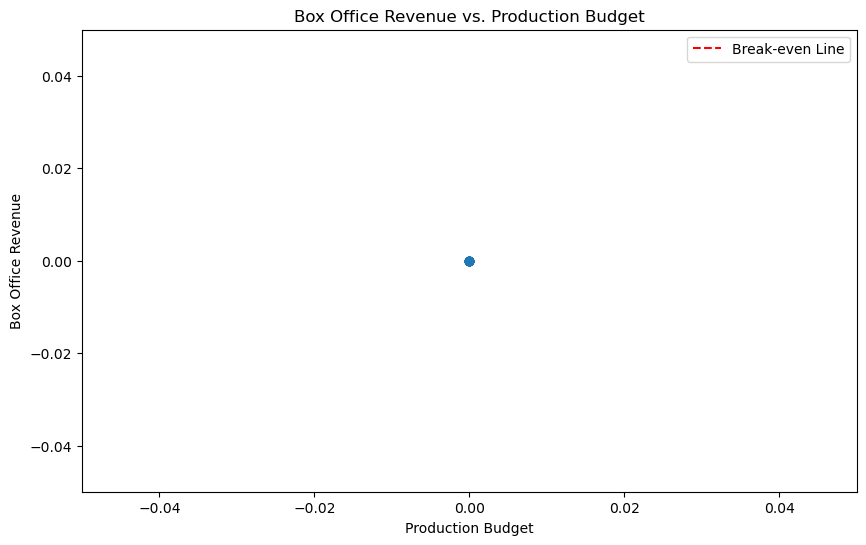

In [42]:
import matplotlib.pyplot as plt
import numpy as np


# Convert data types and replace invalid values
merged_data['production_budget'] = pd.to_numeric(merged_data['production_budget'], errors='coerce').fillna(0)
merged_data['worldwide_gross'] = pd.to_numeric(merged_data['worldwide_gross'], errors='coerce').fillna(0)

# Calculate maximum values, ignoring NaN and Inf
budget_max = merged_data['production_budget'].replace([np.inf, -np.inf], np.nan).dropna().max()
gross_max = merged_data['worldwide_gross'].replace([np.inf, -np.inf], np.nan).dropna().max()

# Set axis limits with buffer
budget_max *= 1.2
gross_max *= 1.2

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['production_budget'], merged_data['worldwide_gross'], alpha=0.5)
plt.plot([0, budget_max], [0, budget_max], 'r--', label='Break-even Line')
plt.xlabel('Production Budget')
plt.ylabel('Box Office Revenue')
plt.title('Box Office Revenue vs. Production Budget')
plt.xlim(0, budget_max)
plt.ylim(0, gross_max)
plt.legend()
plt.show()

In [ ]:
# Genre Distribution Bar Chart

genre_counts = pd.Series(merged_data['genre'].explode()).value_counts()
plt.figure(figsize=(10, 6))
genre_counts.sort_values(ascending=False).plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Genre Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Movie Runtime Histogram

plt.figure(figsize=(10, 6))
plt.hist(merged_data['runtime_minutes'], bins=20, edgecolor='black')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.title('Movie Runtime Distribution')
plt.show()

In [ ]:
# Average Rating vs. Number of Votes Scatter Plot

plt.figure(figsize=(10, 6))
plt.scatter(merged_data['numvotes'], merged_data['averagerating'], alpha=0.5)
plt.xlabel('Number of Votes')
plt.ylabel('Average Rating')
plt.title('Average Rating vs. Number of Votes')
plt.show()

In [ ]:
# Time Series of Movie Releases

release_dates = pd.to_datetime(merged_data['release_date'])
release_counts = release_dates.dt.year.value_counts().sort_index()

plt.figure(figsize=(10, 6))
release_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Movie Releases')
plt.title('Movie Releases Over Time')
plt.show()

In [69]:
tmdb_movies['release_year'] = pd.to_datetime(tmdb_movies['release_date']).dt.year

# Categorize movies based on vote_average
bins = [0, 5, 7, 10]
labels = ['Low', 'Medium', 'High']
tmdb_movies['rating_category'] = pd.cut(tmdb_movies['vote_average'], bins=bins, labels=labels)

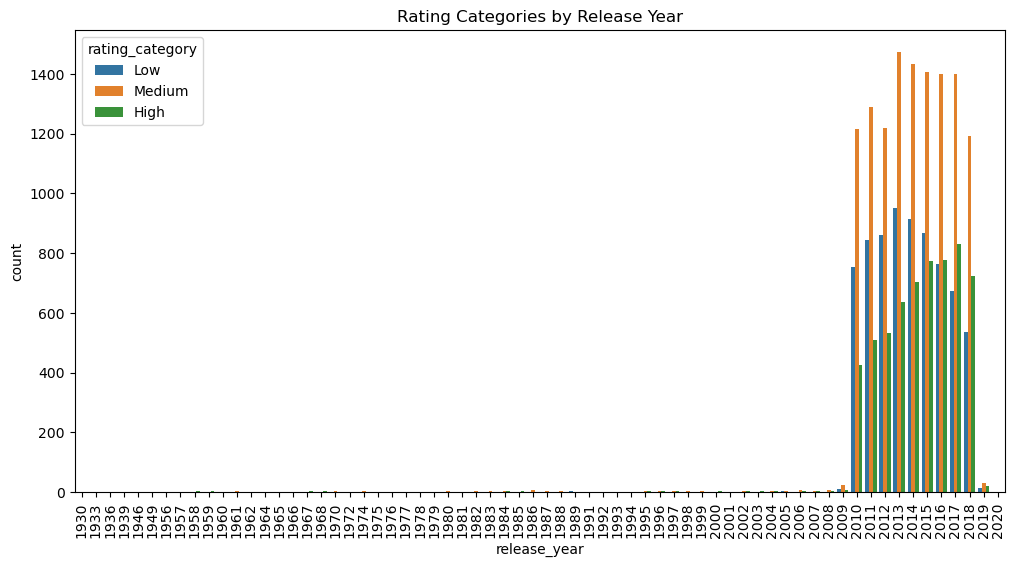

<Figure size 1200x600 with 0 Axes>

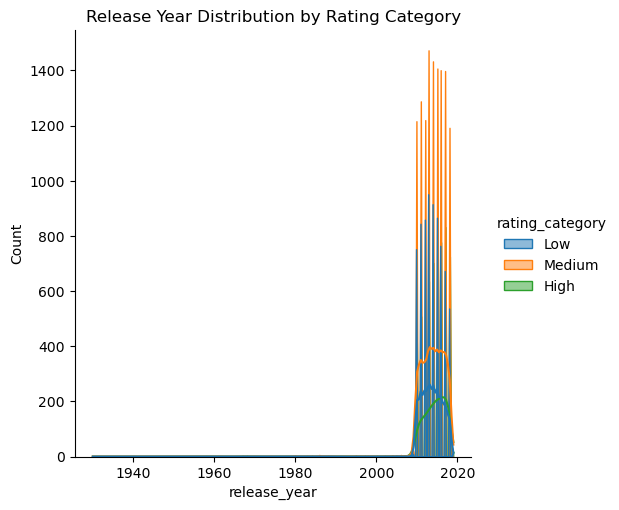

In [70]:
# Count plot for rating categories over the years
plt.figure(figsize=(12, 6))
sns.countplot(data=tmdb_movies, x='release_year', hue='rating_category', order=sorted(tmdb_movies['release_year'].unique()))
plt.xticks(rotation=90)
plt.title('Rating Categories by Release Year')
plt.show()

# Distribution of release years for each rating category
plt.figure(figsize=(12, 6))
sns.displot(data=tmdb_movies, x='release_year', hue='rating_category', element='poly', common_norm=False, multiple='dodge', kde=True)
plt.title('Release Year Distribution by Rating Category')
plt.show()

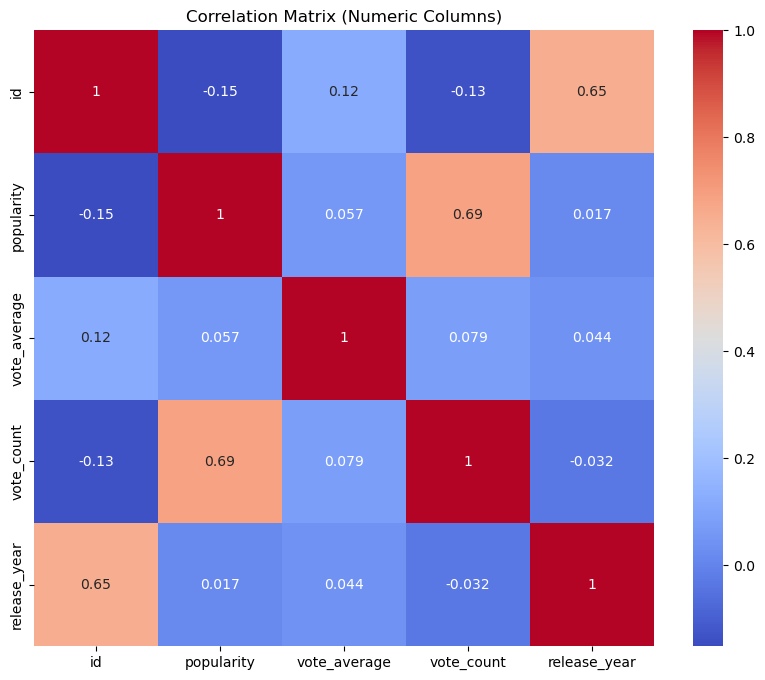

In [71]:
numeric_cols = tmdb_movies.select_dtypes(include=[np.number]).columns

# Compute correlation matrix for numeric columns
corr_matrix = tmdb_movies[numeric_cols].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Columns)')
plt.show()

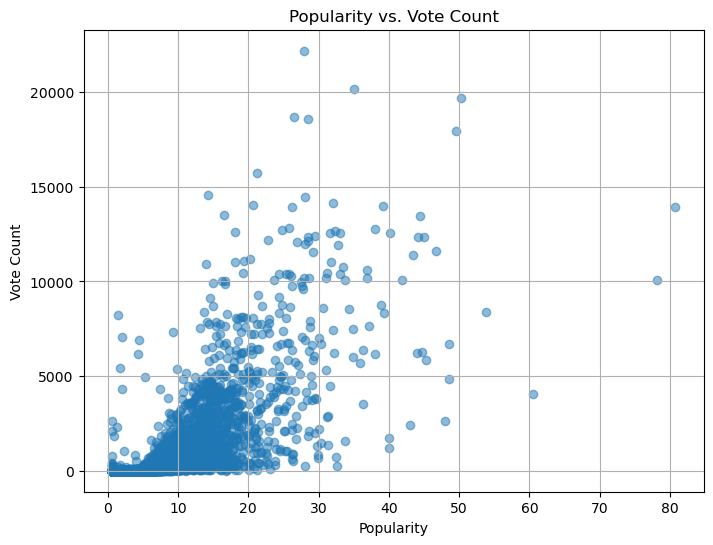

In [72]:
# I want to look more at popularity x vote_count at 0.69
plt.figure(figsize=(8, 6))
plt.scatter(tmdb_movies['popularity'], tmdb_movies['vote_count'], alpha=0.5)
plt.xlabel('Popularity')
plt.ylabel('Vote Count')
plt.title('Popularity vs. Vote Count')
plt.grid(True)
plt.show()

As expected, there is a strong positive linear relationship between Popularity and Vote Count. This is expected, since the more excited you are about a movie, the more likely you are to vote for it / give it a rating.

## Data Visualizations

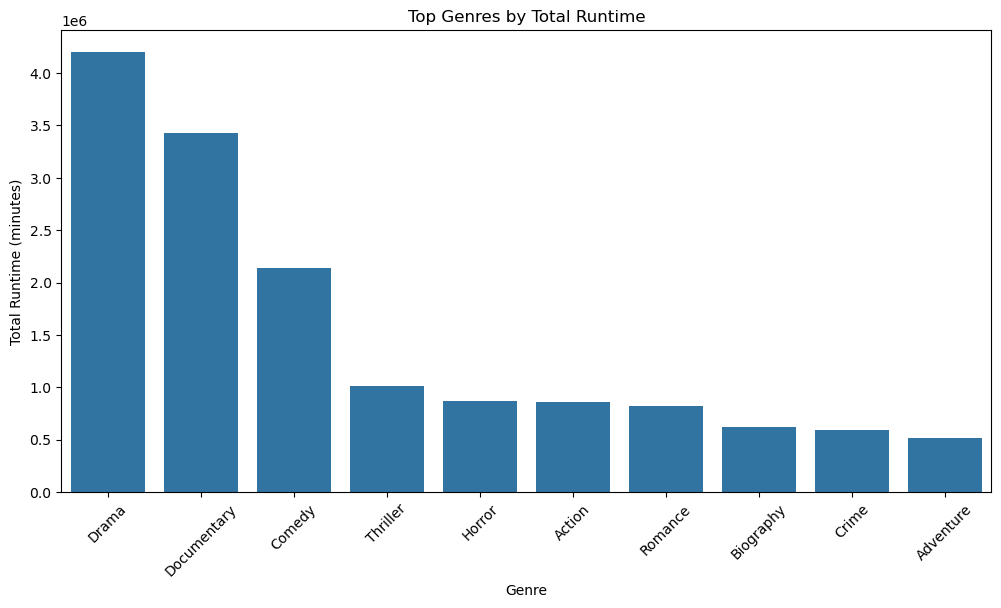

In [73]:
# Genre Analysis

# Split the 'genres' column into a list
imdb['genres'] = imdb['genres'].str.split(',')

# Explode the 'genres' column to create a new row for each genre
imdb = imdb.explode('genres')

# Group by genre and calculate the sum of runtime_minutes
genre_runtime = imdb.groupby('genres')['runtime_minutes'].sum().reset_index()
genre_runtime = genre_runtime.sort_values(by='runtime_minutes', ascending=False)

# Visualize the top genres by total runtime
plt.figure(figsize=(12, 6))
sns.barplot(x='genres', y='runtime_minutes', data=genre_runtime.head(10))
plt.xticks(rotation=45)
plt.title('Top Genres by Total Runtime')
plt.xlabel('Genre')
plt.ylabel('Total Runtime (minutes)')
plt.show()

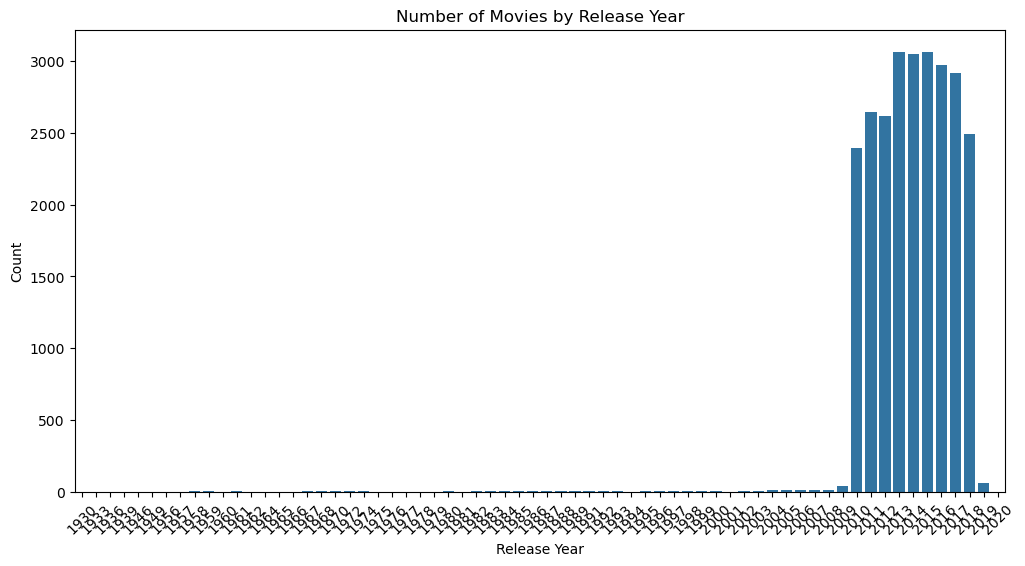

In [74]:
# Release Year trends
plt.figure(figsize=(12, 6))
sns.countplot(x='release_year', data=tmdb_movies)
plt.xticks(rotation=45)
plt.title('Number of Movies by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

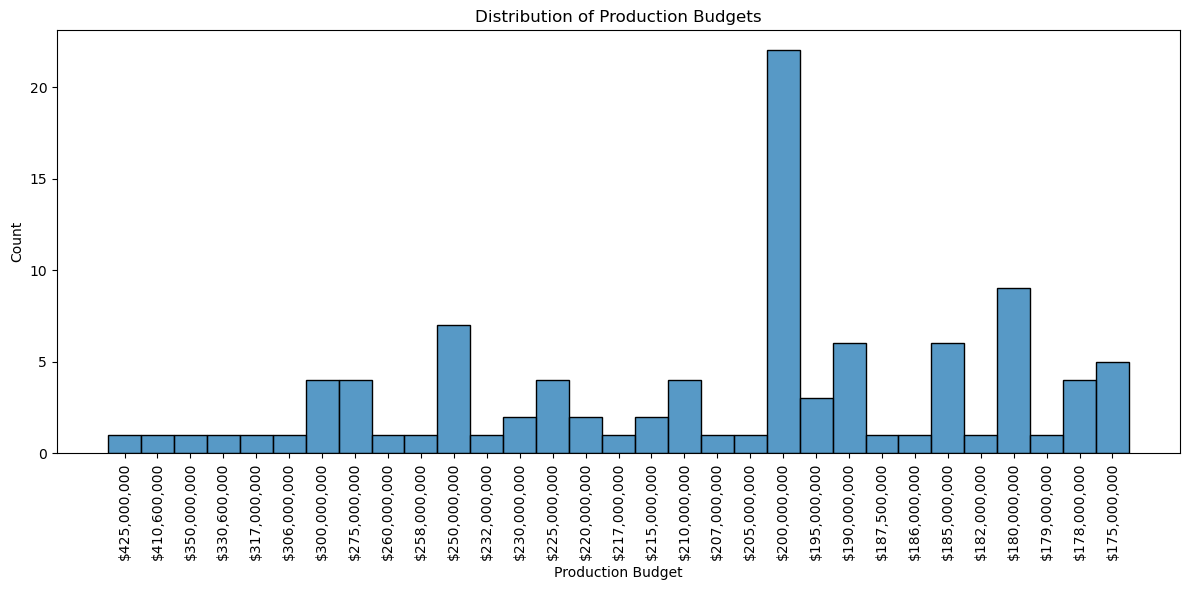

count              100
unique              31
top       $200,000,000
freq                22
Name: production_budget, dtype: object

In [75]:
# Distribution of production budgets
plt.figure(figsize=(12, 6))
sns.histplot(data=tn_budgets, x='production_budget', bins=20)
plt.xticks(rotation=90)
plt.title('Distribution of Production Budgets')
plt.xlabel('Production Budget')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

tn_budgets['production_budget'].describe()

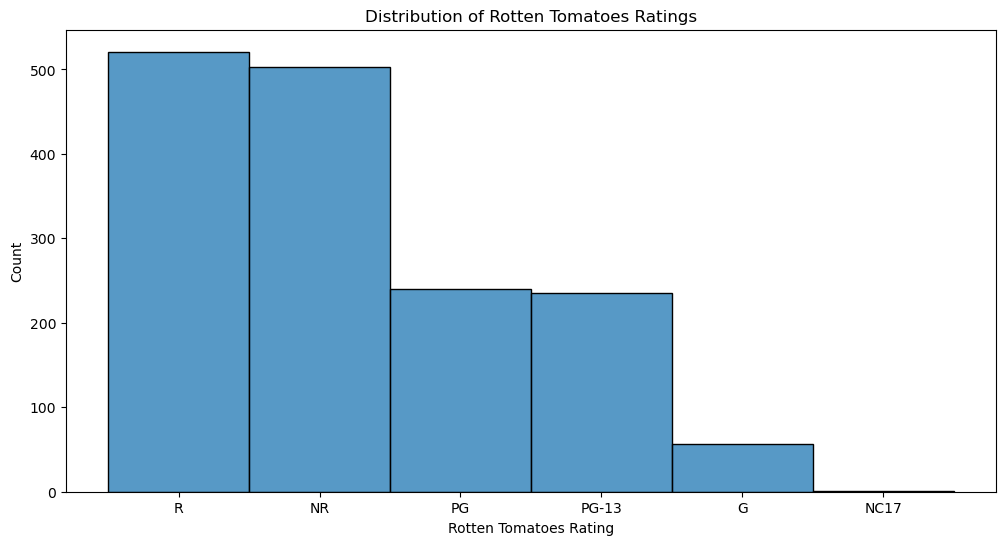

In [76]:
# Critical Ratings (rotten tomato)
plt.figure(figsize=(12, 6))
sns.histplot(data=rt_info, x='rating', bins=20)
plt.title('Distribution of Rotten Tomatoes Ratings')
plt.xlabel('Rotten Tomatoes Rating')
plt.ylabel('Count')
plt.show()

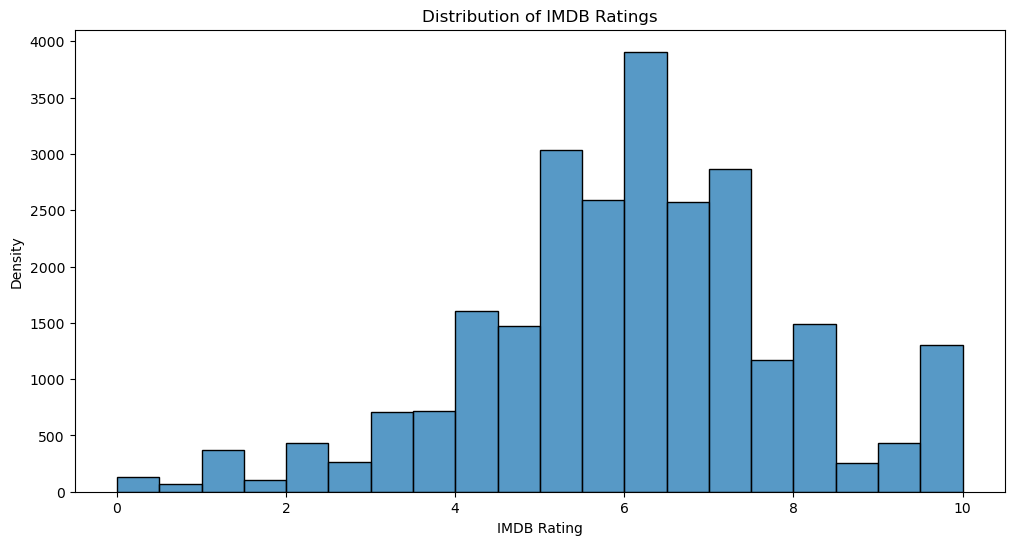

In [77]:
# dist of imdb ratings
plt.figure(figsize=(12, 6))
sns.histplot(tmdb_movies['vote_average'], bins=20)
plt.title('Distribution of IMDB Ratings')
plt.xlabel('IMDB Rating')
plt.ylabel('Density')
plt.show()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

<Figure size 1200x800 with 0 Axes>

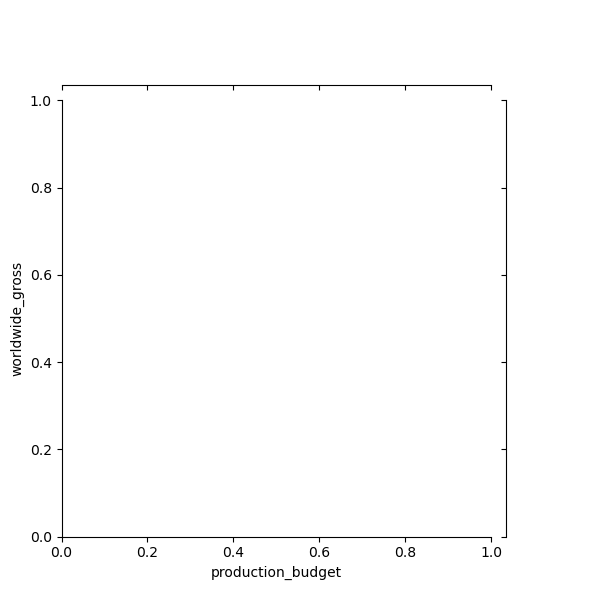

In [79]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=tn_budgets, x='production_budget', y='worldwide_gross')

plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Production Budget vs. Worldwide Gross')
plt.tight_layout()
plt.show()

In [21]:
rt_info.head(20)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,title,runtime_minutes
0,1,"This gritty, fast-paced, and innovative police...",NaN,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,NaN,104.0
1,3,"New York City, not-too-distant-future: Eric Pa...",NaN,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,"New York City, not-too-distant-future",108.0
2,5,Illeana Douglas delivers a superb performance ...,NaN,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN,NaN,116.0
3,6,Michael Douglas runs afoul of a treacherous su...,NaN,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN,NaN,128.0
4,7,NaN,NaN,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN,NaN,200.0
5,8,The year is 1942. As the Allies unite overseas...,NaN,Drama|Kids and Family,Jay Russell,Gail Gilchriest,"Mar 3, 2000","Jul 11, 2000",NaN,NaN,95 minutes,Warner Bros. Pictures,The year is 1942. As the Allies unite overseas...,95.0
6,10,Some cast and crew from NBC's highly acclaimed...,NaN,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",82 minutes,Paramount Pictures,NaN,82.0
7,13,"Stewart Kane, an Irishman living in the Austra...",NaN,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",123 minutes,Sony Pictures Classics,NaN,123.0
8,14,"""Love Ranch"" is a bittersweet love story that ...",NaN,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",$,"134,904",117 minutes,NaN,NaN,117.0
9,15,When a diamond expedition in the Congo is lost...,NaN,Action and Adventure|Mystery and Suspense|Scie...,Frank Marshall,John Patrick Shanley,"Jun 9, 1995","Jul 27, 1999",NaN,NaN,108 minutes,NaN,NaN,108.0


In [18]:
tn_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
